# PySpark Tutorial 

> How to initialize `Spark.Session` and to use HDFS

## Install basic packages for pyspark, astropy, pyarrow, pandas, scipy, and etc.

In [1]:
#!pip3 install -U pip setuptools wheel

In [2]:
#!pip3 install -U numpy scipy pandas koalas pyarrow scikit-learn matplotlib astropy astroML

In [3]:
pip list |grep astro

astroid                            2.3.1          
astroML                            0.4.1          
astropy                            3.2.2          
pytest-astropy                     0.5.0          
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip list |grep pyarrow

pyarrow                            0.17.0         
Note: you may need to restart the kernel to use updated packages.


## Browse HDFS file systems 

#### Local file system

In [5]:
!pwd

/home/shong/work/tutorial


In [6]:
!ls

BreadBasket_DMS.csv  tutorial-pyspark-standalone-hdfs.ipynb


#### Hadoop File System (HDFS)

In [7]:
!hadoop fs -ls /misc/tutorial/

Found 1 items
-rw-r--r--   2 shong supergroup     710518 2023-10-17 13:30 /misc/tutorial/BreadBasket_DMS.csv


In [8]:
!hadoop fs -help

Usage: hadoop fs [generic options]
	[-appendToFile <localsrc> ... <dst>]
	[-cat [-ignoreCrc] <src> ...]
	[-checksum <src> ...]
	[-chgrp [-R] GROUP PATH...]
	[-chmod [-R] <MODE[,MODE]... | OCTALMODE> PATH...]
	[-chown [-R] [OWNER][:[GROUP]] PATH...]
	[-copyFromLocal [-f] [-p] [-l] [-d] <localsrc> ... <dst>]
	[-copyToLocal [-f] [-p] [-ignoreCrc] [-crc] <src> ... <localdst>]
	[-count [-q] [-h] [-v] [-t [<storage type>]] [-u] [-x] <path> ...]
	[-cp [-f] [-p | -p[topax]] [-d] <src> ... <dst>]
	[-createSnapshot <snapshotDir> [<snapshotName>]]
	[-deleteSnapshot <snapshotDir> <snapshotName>]
	[-df [-h] [<path> ...]]
	[-du [-s] [-h] [-x] <path> ...]
	[-expunge]
	[-find <path> ... <expression> ...]
	[-get [-f] [-p] [-ignoreCrc] [-crc] <src> ... <localdst>]
	[-getfacl [-R] <path>]
	[-getfattr [-R] {-n name | -d} [-e en] <path>]
	[-getmerge [-nl] [-skip-empty-file] <src> <localdst>]
	[-help [cmd ...]]
	[-ls [-C] [-d] [-h] [-q] [-R] [-t] [-S] [-r] [-u] [<path> ...]]
	[-mkdir [-p] <path> ...]
	[-mov

## Import Basic Libraries

In [9]:
# generate edges 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import gc

# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [10]:
import pyarrow.parquet as pq

In [12]:
# PySpark packages
from pyspark import SparkContext   
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W


spark = SparkSession.builder \
    .master("spark://master:7077") \
    .appName("pyspark-shell") \
    .getOrCreate()


sc = spark.sparkContext
sc.setCheckpointDir("hdfs://master:54310/tmp/spark/checkpoints")

spark.conf.set("spark.sql.debug.maxToStringFields", 500)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [13]:
sc.getConf().getAll()

[('spark.driver.port', '44551'),
 ('spark.master', 'spark://master:7077'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'app-20231017134300-0000'),
 ('spark.driver.host', 'master'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'pyspark-shell')]

## Tutorial Getting Pi

In [14]:
from random import random
from operator import add

In [15]:
partitions = 5
n = 1000000 * partitions

In [16]:
def f(_):
    x = np.random.rand() * 2.0 - 1.0
    y = np.random.rand() * 2.0 - 1.0
    return 1 if x ** 2 + y ** 2 <= 1.0 else 0

In [17]:
%%time
count = sc.parallelize(range(1, n + 1), partitions).map(f).reduce(add)
print("Pi is roughly %.20f" % (4.0 * count / n))

Pi is roughly 3.14304719999999981894
CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 2.59 s


## Reading data from HDFS 

In [18]:
bakery_schema = T.StructType([
    T.StructField('date', T.StringType(), True),
    T.StructField('time', T.StringType(), True),
    T.StructField('transaction', T.IntegerType(), True),
    T.StructField('item', T.StringType(), True)
])

In [19]:
df = spark.read \
    .format('csv') \
    .option('header','true') \
    .load('hdfs://master:54310/misc/tutorial/BreadBasket_DMS.csv', schema=bakery_schema)

In [20]:
%%time
df.show(10)

+----------+--------+-----------+-------------+
|      date|    time|transaction|         item|
+----------+--------+-----------+-------------+
|2016-10-30|09:58:11|          1|        Bread|
|2016-10-30|10:05:34|          2| Scandinavian|
|2016-10-30|10:05:34|          2| Scandinavian|
|2016-10-30|10:07:57|          3|Hot chocolate|
|2016-10-30|10:07:57|          3|          Jam|
|2016-10-30|10:07:57|          3|      Cookies|
|2016-10-30|10:08:41|          4|       Muffin|
|2016-10-30|10:13:03|          5|       Coffee|
|2016-10-30|10:13:03|          5|       Pastry|
|2016-10-30|10:13:03|          5|        Bread|
+----------+--------+-----------+-------------+
only showing top 10 rows

CPU times: user 1.64 ms, sys: 1.02 ms, total: 2.65 ms
Wall time: 1.89 s


In [21]:
%%time
df.describe().show()

+-------+----------+--------+------------------+----------------+
|summary|      date|    time|       transaction|            item|
+-------+----------+--------+------------------+----------------+
|  count|     21293|   21293|             21293|           21293|
|   mean|      null|    null| 4951.990889024562|            null|
| stddev|      null|    null|2787.7583996983885|            null|
|    min|2016-10-30|01:21:05|                 1|      Adjustment|
|    max|2017-04-09|23:38:41|              9684|Victorian Sponge|
+-------+----------+--------+------------------+----------------+

CPU times: user 4.19 ms, sys: 96 µs, total: 4.29 ms
Wall time: 2.3 s


## Testing Levy Walks

In [22]:
from scipy.stats import uniform

In [23]:
def levy_periodic(rzero,inpow,x,y,z,sysL=1.0):
    # 3-D Levy Walks
    tmppi = uniform.rvs(loc=0.0,scale=2.*np.pi)
    tmpcos = 2.0*uniform.rvs() - 1.0
    tmpsin = np.sqrt(1.0 - tmpcos*tmpcos)  
    tmpl = rzero * np.power(uniform.rvs(), -1.0/inpow)
    
    nx = x + tmpl * tmpsin * np.cos(tmppi)
    ny = y + tmpl * tmpsin * np.sin(tmppi)
    nz = z + tmpl * tmpcos
    
    #print(x,y,z,nx,ny,nz)
    
    # Periodic Boundary
    if nx >= sysL:
        nx = nx - sysL * np.floor(nx/sysL)
    if ny >= sysL:
        ny = ny - sysL * np.floor(ny/sysL)
    if nz >= sysL:
        nz = nz - sysL * np.floor(nz/sysL)
    
    if nx < 0.0:
        nx = nx + sysL * (1.0 + np.floor(np.abs(nx)/sysL))
    if ny < 0.0:
        ny = ny + sysL * (1.0 + np.floor(np.abs(ny)/sysL))
    if nz < 0.0:
        nz = nz + sysL * (1.0 + np.floor(np.abs(nz)/sysL))
        
    return np.double([nx,ny,nz,tmpl])

In [24]:
# test the first Levy Walk
levy_periodic(1.0,1.2,0.0,0.0,0.0,sysL=100)

array([ 2.04187095,  0.31185311, 98.93927357,  2.32198835])

In [25]:
levy_periodic(1.0,1.2,0.5,0.5,0.5,sysL=1.0)

array([0.74075683, 0.50636256, 0.18286983, 2.74514808])

In [26]:
xlv = []
ylv = []
zlv = []
llv = []
numlv = 2000

walker = np.double([0.5,0.5,0.5,0.5])

#xlv.append(walker[0])
#ylv.append(walker[1])
#zlv.append(walker[2])
#llv.append(walker[3])
for i in range(numlv):
    walker = levy_periodic(0.01,1.2,walker[0],walker[1],walker[2],sysL=1.0)
    xlv.append(walker[0])
    ylv.append(walker[1])
    zlv.append(walker[2])
    llv.append(walker[3])

## Measuring Two-point Functions

In [27]:
from astroML.correlation import two_point

In [28]:
Xlv = np.stack([xlv,ylv,zlv],axis=1)

In [29]:
bins, binstep = np.linspace(np.log10(0.005), np.log10(1.0), 25, retstep=True)

In [30]:
xbins = bins[1:] - binstep*0.5
xbins = np.power(10,xbins)

In [31]:
bins = np.power(10,bins)

In [32]:
corr = two_point(Xlv, bins)

In [33]:
corr.shape

(24,)

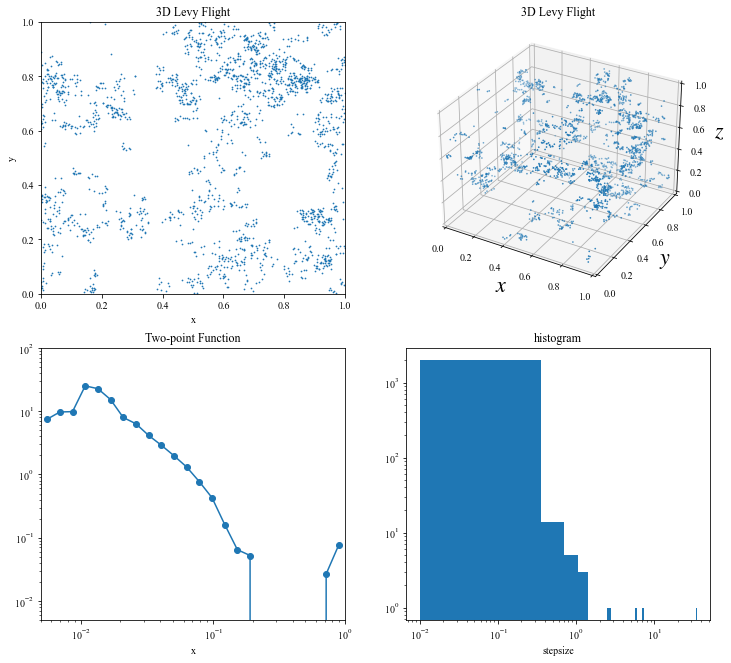

In [34]:
from mpl_toolkits.mplot3d import Axes3D


# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 14})
plt.rcParams['mathtext.fontset'] = 'stix'

# initialize figure
fig = plt.figure( figsize=(12,11) )

# plot 2D random walk with Levy stepsize
plt.subplot(221)
plt.axis([0,1,0,1])
plt.scatter( xlv, ylv, s=0.5 )
plt.xlabel( 'x' )
plt.ylabel( 'y' )
plt.title(r'3D Levy Flight' )

ax = fig.add_subplot(222, projection='3d')
ax.set_title(r'3D Levy Flight')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.scatter(xlv,ylv,zlv,s=0.5)
ax.set_xlabel(r'$x$',fontsize=22)
ax.set_ylabel(r'$y$',fontsize=22)
ax.set_zlabel(r'$z$',fontsize=22)

# plot histogram
plt.subplot(223)

plt.axis([0.005,1,0.005,100])
plt.yscale( 'log' )
plt.xscale( 'log' )
plt.xlabel( 'x' )
plt.title( 'Two-point Function' )
plt.scatter(xbins,corr)
plt.plot(xbins,corr)

# plot histogram
plt.subplot(224)
#num_bins = n/10
plt.hist( llv, bins=100 )
plt.yscale( 'log' )
plt.xscale( 'log' )
plt.xlabel( 'stepsize' )
plt.title( 'histogram' )

plt.show()

> 20000 training sample and 7000 testing sample 

In [35]:
pwd

'/home/shong/work/tutorial'